In [1]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

In [2]:
from typing import Union

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from analysis.helper import (postgres_data, format_genre,
                             GENRES, PLATFORMS, COLORS)

import warnings
warnings.filterwarnings('ignore')

## **Overview Platforms**

### **Superficial Analysis of the `games` table**

In [3]:
# List of available games
games_df = {}
for platform in PLATFORMS:
    games_df[platform] = postgres_data(platform, 'games')

games_df[PLATFORMS[0]].head(3)

,gameid,title,developers,publishers,genres,supported_languages,release_date
0,3281560,Horror Game To Play With Friends! Playtest,None,None,None,None,2024-10-21
1,3280930,Eternals' Path Playtest,None,None,None,None,2024-10-17
2,3280770,ANGST: A TALE OF SURVIVAL - Singleplayer Playtest,None,None,None,None,2024-10-13


**Let's preprocess the data:**
* **Remove betatests, playtests**
* We will exclude only those records where all columns `developers`, `publishers`, `genres`,  
and `release_date` - contain missing values, to preserve valuable information
* **Exclude** games with **multiple release regions**

In [4]:
for platform in PLATFORMS:
    games_df[platform] = games_df[platform][~games_df[platform].title.str.endswith('Playtest')]

    games_df[platform] = games_df[platform] \
        .dropna(subset=['developers', 'publishers', 'genres', 'release_date'], how='all') \
        .reset_index(drop=True)
    
    if platform != 'playstation':
        # Add a column to avoid catching an Exception
        games_df[platform]['platform'] = platform
    games_df[platform].drop_duplicates(subset=['title', 'platform', 'release_date'], inplace=True)

    # games_df[platform].to_csv(f'resources/games_{platform}.csv', index=False)

games_df[PLATFORMS[0]].head(3)

,gameid,title,developers,publishers,genres,supported_languages,release_date,platform
0,3278740,NEURO,[Revolt Games],[Strategy First],[Action],"[English, Russian]",2024-10-11,steam
1,3270850,Keep Your Eyes Open,[Texerikus],[Texerikus],[Indie],[English],2024-10-21,steam
2,3267350,Tiny Shooters,[madilumar],[Thetinyverse],"[Action, Free To Play]",[English],2024-10-19,steam


Total number of games for each platform

In [5]:
for platform in PLATFORMS:
    print(f'{platform.capitalize().replace("s", "S")}: Games - {games_df[platform].shape[0]}')

Steam: Games - 93073
PlayStation: Games - 15640
Xbox: Games - 10489


Analyze the **trend** of game releases **by year** for each platform

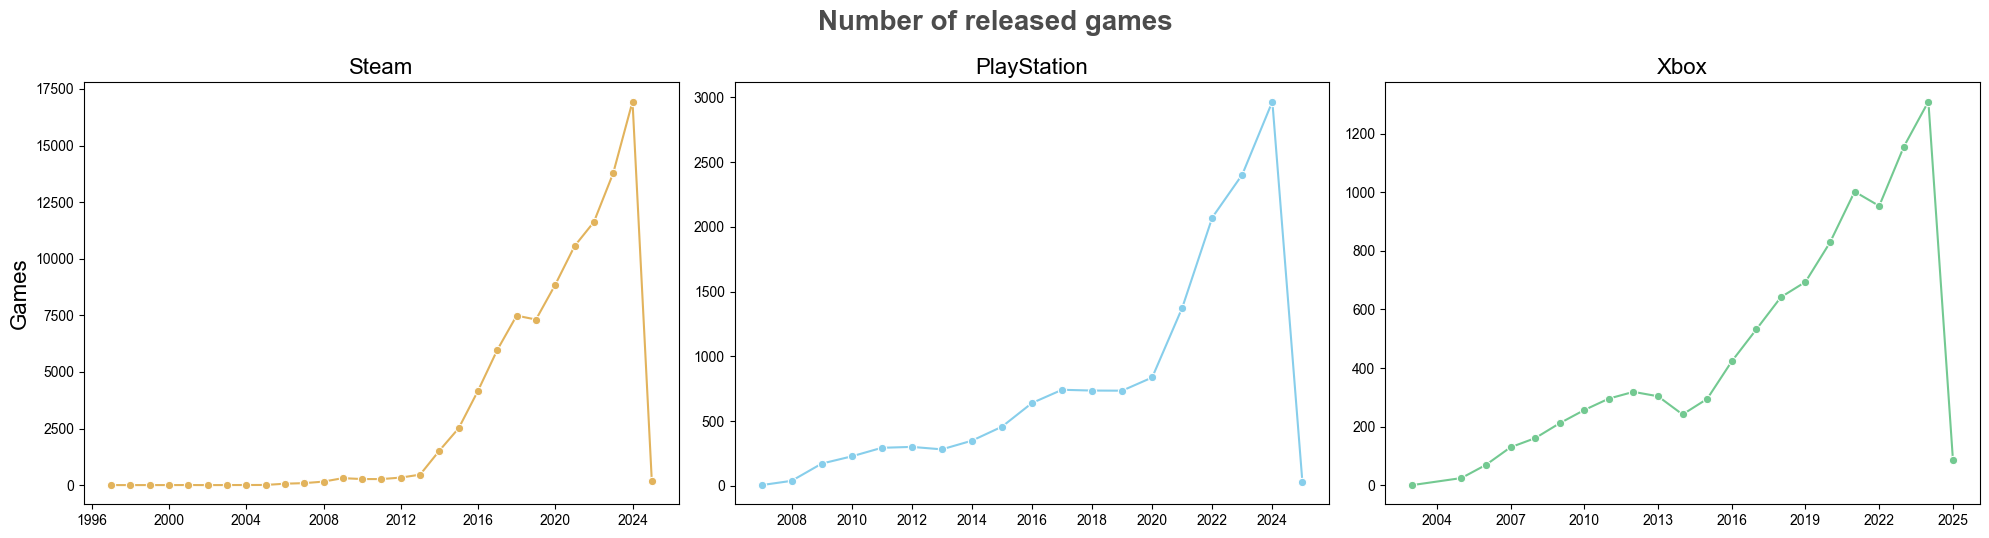

In [6]:
plt.rcParams['font.family'] = 'Arial'
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, color, platform in zip(axes, COLORS, PLATFORMS):
    releases = (
        games_df[platform]
        .release_date.dt.year
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'quantity'})
    )
    
    sns.lineplot(x=releases.release_date, y=releases.quantity,
                 ax=ax, color=color, marker='o')
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    ax.set_title(platform.capitalize().replace('s', 'S'), fontsize=16)
    ax.set_xlabel('')

axes[0].set_ylabel('Games', fontsize=16)
axes[1].set_ylabel('')
axes[2].set_ylabel('')

fig.text(.5, 1.04, 'Number of released games',
         ha='center', va='center', fontsize=20, weight='bold', alpha=.7)

plt.tight_layout()

There is a noticeable increase in the number of games released for each platform. `Steam` consistently has the highest number of releases per year compared to its competitors  
This is likely due to **`Steam's` more developer-friendly policies**, whereas developing for `Xbox` and `PlayStation` often requires more resources and effort  

***Let’s verify the hypothesis that a significant portion of games on `Steam` are indie projects***


In [7]:
# Refine data preprocessing: standardize genre names
# to a unified format and remove irrelevant categories
all_platforms = pd.DataFrame()
for platform in PLATFORMS:
    genres = games_df[platform].explode('genres')
    
    genres.genres = genres.genres.apply(format_genre)
    genres = genres[genres.genres.isin(GENRES)]

    genres = (
        genres.genres
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'share'})
    )
    
    genres.share = (genres.share / games_df[platform].shape[0] * 100).round(2)

    all_platforms = pd.concat([all_platforms, genres.assign(platform=platform.capitalize())])

pivoted_frequency = (
    all_platforms
    .pivot(index='genres', columns='platform', values='share')
    .fillna(.0)
    .sort_values(['Steam', 'Playstation', 'Xbox'], ascending=False)
)

pivoted_frequency.head(3)

platform,Playstation,Steam,Xbox
genres,,,
Indie,6.50,69.95,6.05
Casual,2.06,42.88,1.74
Action,17.52,41.17,25.21


> **Note:** The genre proportions are independent of each other (the total will not sum to 100%, as a single game can belong to multiple genres)

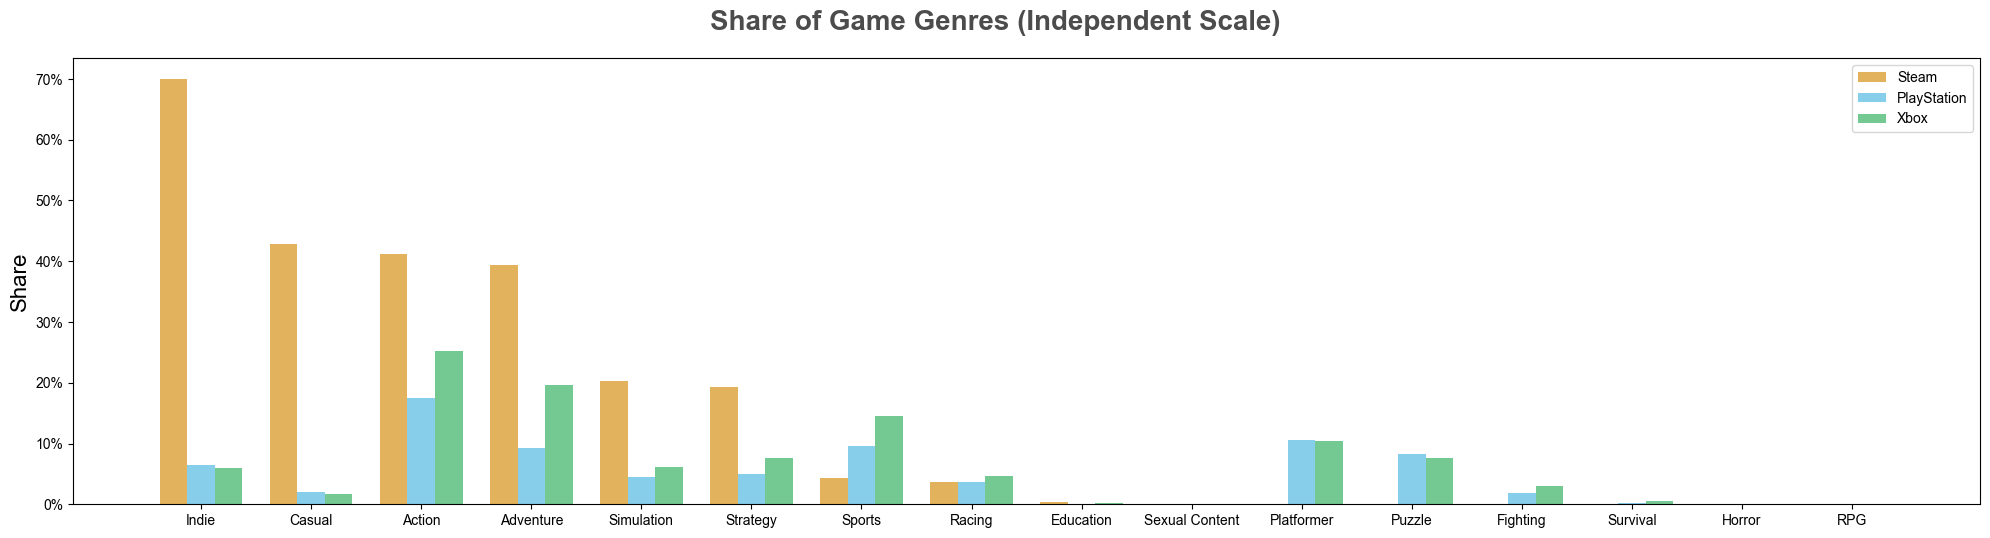

In [8]:
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(20, 5))

bar_width = .25
x = np.arange(len(pivoted_frequency))

for i, (color, platform) in enumerate(zip(COLORS, PLATFORMS)):
    platform = platform.capitalize()

    ax.bar(x + i * bar_width, pivoted_frequency[platform], bar_width,
           label=platform.replace('s', 'S'), color=color)

ax.set_xticks(x + bar_width)
ax.set_xticklabels(pivoted_frequency.index)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}%'))
ax.set_ylabel('Share', fontsize=16)

ax.legend()

fig.text(.5, 1.04, 'Share of Game Genres (Independent Scale)',
         ha='center', va='center', fontsize=20, weight='bold', alpha=.7)

plt.tight_layout()

> Now, let's identify which publishers and developers release games most frequently

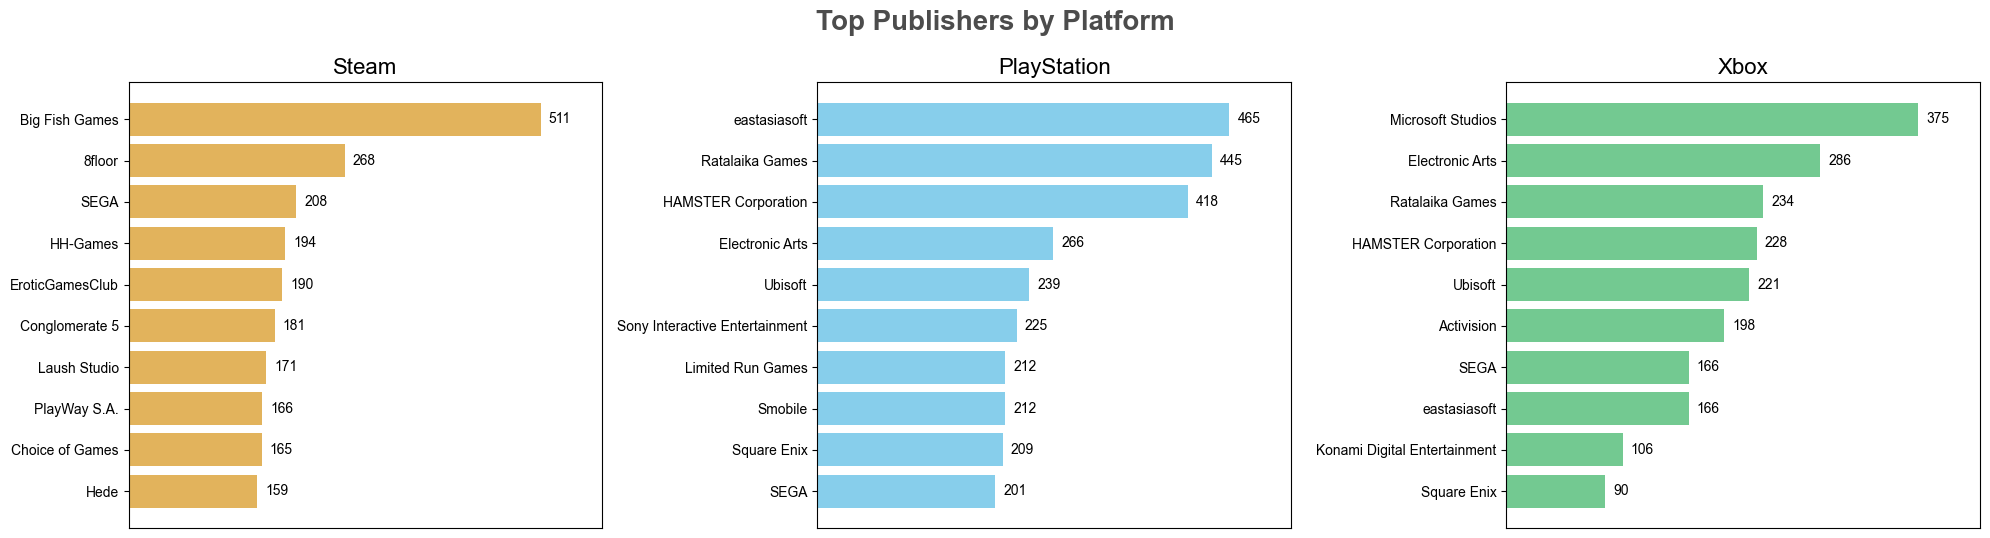

In [9]:
plt.rcParams['font.family'] = 'Arial'
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, platform, color in zip(axes, PLATFORMS, COLORS):
    top_publishers = (
        games_df[platform]
        .explode('publishers')
        .publishers
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'quantity'})
        .head(10)
    )

    bars = ax.barh(top_publishers.publishers, top_publishers.quantity, color=color)

    ax.set_xlim(0, top_publishers.quantity.max() * 1.15)

    for bar, quantity in zip(bars, top_publishers.quantity):
        ax.text(
            bar.get_width() + top_publishers.quantity.max() * .02,
            bar.get_y() + bar.get_height() / 2,
            str(quantity),
            va='center',
            ha='left',
            fontsize=10
        )

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_title(platform.capitalize().replace('s', 'S'), fontsize=16)

fig.text(.5, 1.04, 'Top Publishers by Platform',
         ha='center', va='center', fontsize=20, weight='bold', alpha=.7)

plt.tight_layout()

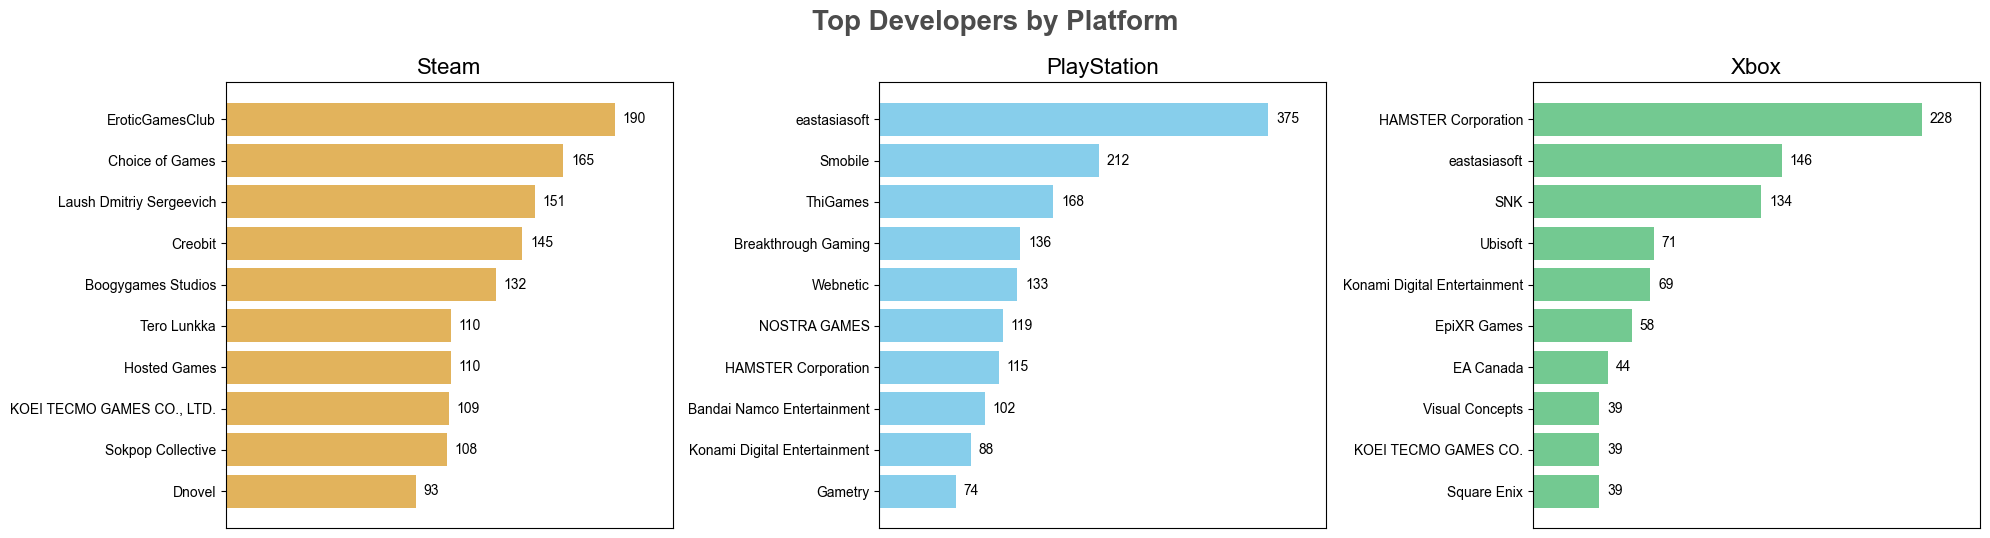

In [10]:
plt.rcParams['font.family'] = 'Arial'
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, platform, color in zip(axes, PLATFORMS, COLORS):
    top_developers = (
        games_df[platform]
        .explode('developers')
        .developers
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'quantity'})
        .head(10)
    )

    bars = ax.barh(top_developers.developers, top_developers.quantity, color=color)

    ax.set_xlim(0, top_developers.quantity.max() * 1.15)

    for bar, quantity in zip(bars, top_developers.quantity):
        ax.text(
            bar.get_width() + top_developers.quantity.max() * .02,
            bar.get_y() + bar.get_height() / 2,
            str(quantity),
            va='center',
            ha='left',
            fontsize=10
        )

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_title(platform.capitalize().replace('s', 'S'), fontsize=16)

fig.text(.5, 1.04, 'Top Developers by Platform',
         ha='center', va='center', fontsize=20, weight='bold', alpha=.7)

plt.tight_layout()

### **Superficial Analysis of the `achievements` table**

In [11]:
# List of all possible achievements
achievements_df = {}
for platform in PLATFORMS:
    achievements_df[platform] = postgres_data(platform, 'achievements')

achievements_df[PLATFORMS[0]].head(3)

,achievementid,gameid,title,description
0,2621440_ACH_FIRST_KILL,2621440,FIRST KILL,You should kill ONE enemy.
1,2621440_ACH_0_LEVEL_COMPLETED,2621440,TUTORIAL COMPLETED,You should complete tutorial.
2,2621440_ACH_1_LEVEL_COMPLETED,2621440,FIRST LEVEL,You should complete first level


Let's examine the **distribution of the average number of achievements**

Platform policies regarding achievements differ. For instance, both `PlayStation` and `Xbox` require each game to have **at least one achievement**,  
while `Steam` leaves this decision **up to the developer**. We will address this case

In [12]:
# Let's start by examining the std and mean
for platform in PLATFORMS:
    _filter = ~games_df[platform].gameid.isin(achievements_df[platform].gameid.unique())
    games_without_achievements = games_df[platform][_filter]

    # Addressing the case of Steam (games without achievements)
    games_without_achievements['quantity'] = 0
    games_without_achievements = games_without_achievements[['gameid', 'quantity']]

    frequency_achievements = (
        achievements_df[platform]
        .gameid
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'quantity'})
    )
    
    frequency_achievements = pd.concat([frequency_achievements, games_without_achievements])
    
    mean = frequency_achievements.quantity.mean()
    std = frequency_achievements.quantity.std()

    print(f'{platform.capitalize().replace("s", "S")}: Mean = {mean:.2f}, Std = {std:.2f}')

    # Removing outliers where value > μ + 2σ
    achievements_df[platform] = frequency_achievements.query('quantity <= @mean + 2 * @std')

Steam: Mean = 20.74, Std = 170.91
PlayStation: Mean = 27.56, Std = 17.26
Xbox: Mean = 31.02, Std = 23.43


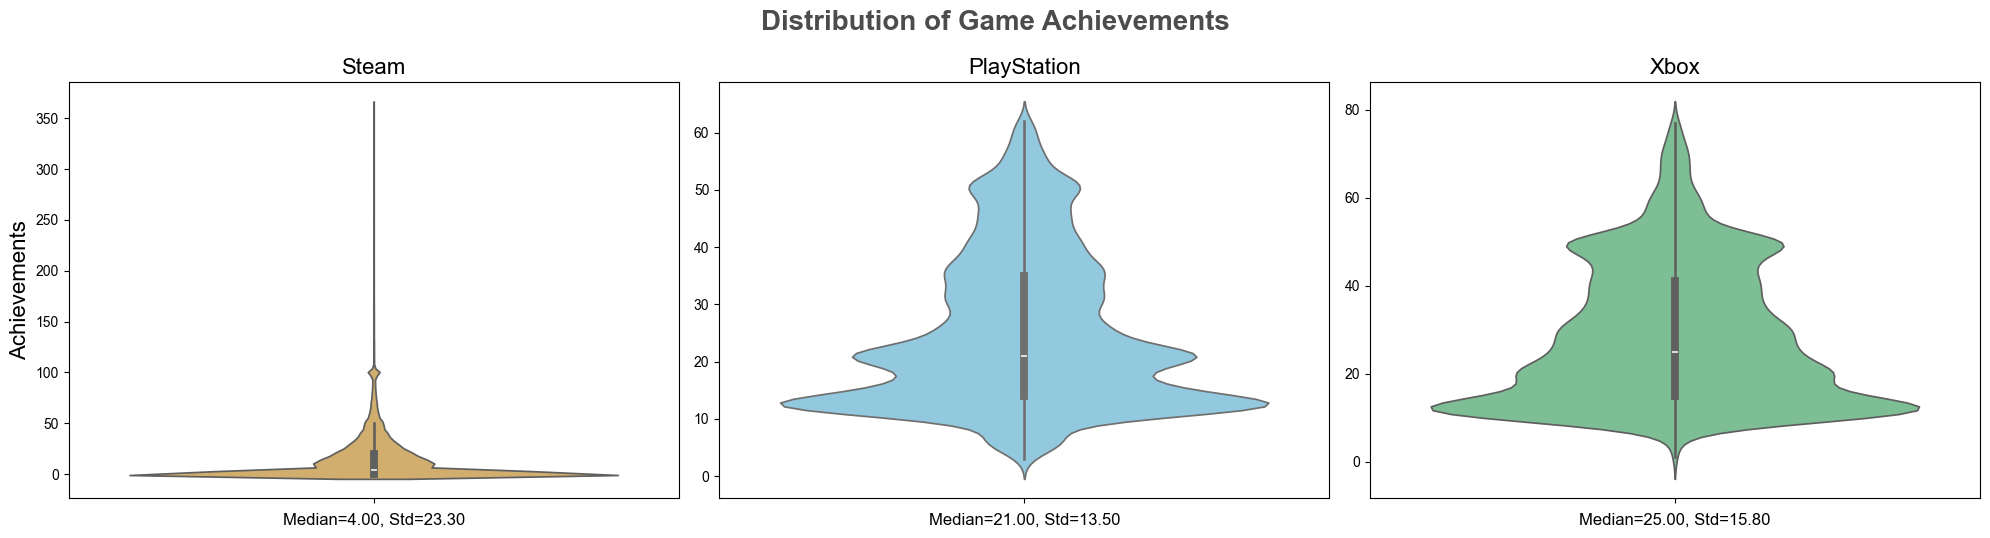

In [13]:
plt.rcParams['font.family'] = 'Arial'
fig, axes = plt.subplots(1, 3, figsize=(20,5))

for ax, color, platform in zip(axes, COLORS, PLATFORMS):
    sns.violinplot(achievements_df[platform].quantity,
                   ax=ax, color=color)
    
    ax.set_ylabel('')
    ax.set_xlabel(
        f'Median={achievements_df[platform].quantity.median():.2f}, ' \
        f'Std={achievements_df[platform].quantity.std():.2f}',
        fontsize=12
    )
    
    ax.set_title(platform.capitalize().replace('s', 'S'), fontsize=16)

axes[0].set_ylabel('Achievements', fontsize=16)

fig.text(.5, 1.04, 'Distribution of Game Achievements',
         ha='center', va='center', fontsize=20, weight='bold', alpha=.7)

plt.tight_layout()

> Let's determine **which of the samples** differ **statistically significantly**

In [14]:
def bootstrap_ci(data: pd.Series,
                 sample_size: int=10000,
                 ci: int=95) -> Union[np.floating, np.floating, np.floating]:
    boot_means = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(sample_size)]

    lower = np.percentile(boot_means, (100 - ci) / 2)
    upper = np.percentile(boot_means, 100 - (100 - ci) / 2)
    
    return np.mean(data), lower, upper

Steam: Mean = 13.90, CI = [13.75, 14.05]
PlayStation: Mean = 25.36, CI = [25.20, 25.51]
Xbox: Mean = 28.69, CI = [28.40, 28.99]


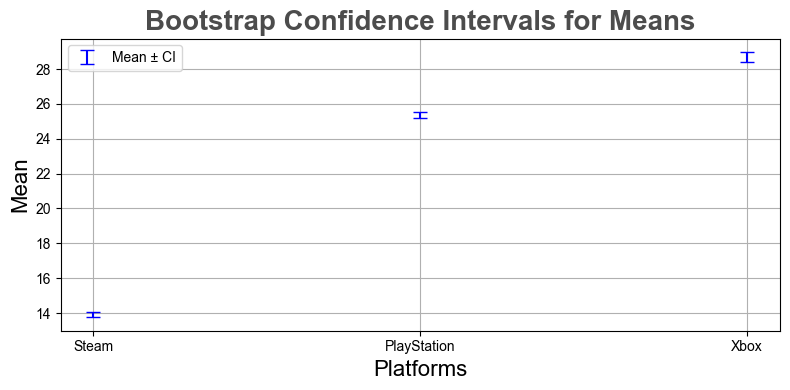

In [15]:
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(8, 4))

results_bootstrap = {}
for platform in PLATFORMS:
    mean, lower, upper = bootstrap_ci(achievements_df[platform].quantity)
    results_bootstrap[platform.capitalize().replace('s', 'S')] = (mean, lower, upper)

for platform, (mean, lower, upper) in results_bootstrap.items():
    print(f'{platform}: Mean = {mean:.2f}, CI = [{lower:.2f}, {upper:.2f}]')

platforms = list(results_bootstrap.keys())
means = [results_bootstrap[platform][0] for platform in platforms]
lowers = [results_bootstrap[platform][1] for platform in platforms]
uppers = [results_bootstrap[platform][2] for platform in platforms]

plt.errorbar(platforms, means, yerr=[np.array(means) - np.array(lowers), np.array(uppers) - np.array(means)], 
             fmt='none', capsize=5, label='Mean ± CI', color='blue')

plt.grid(True)
plt.legend()

plt.ylabel('Mean', fontsize=16)
plt.xlabel('Platforms', fontsize=16)
plt.title('Bootstrap Confidence Intervals for Means', fontsize=20, weight='bold', alpha=.7)

plt.tight_layout()

The average number of achievements per game is highest on `Xbox`, followed by `PlayStation` and `Steam`. **A high number of achievements may discourage players from purchasing**

### **Superficial Analysis of the `players` table**

> Let's determine the **top countries by the usage** of the selected platform  
> **Note:** `PlayStation` does not have the `created` feature, and `Xbox` is not considered (**data is unavailable**)

In [16]:
players_df = {}
for platform in PLATFORMS:
    players_df[platform] = postgres_data(platform, 'players')

players_df[PLATFORMS[0]].head(3)

,playerid,country,created
0,76561198287452552,Brazil,2016-03-02 06:14:20
1,76561198040436563,Israel,2011-04-10 17:10:06
2,76561198049686270,None,2011-09-28 21:43:59


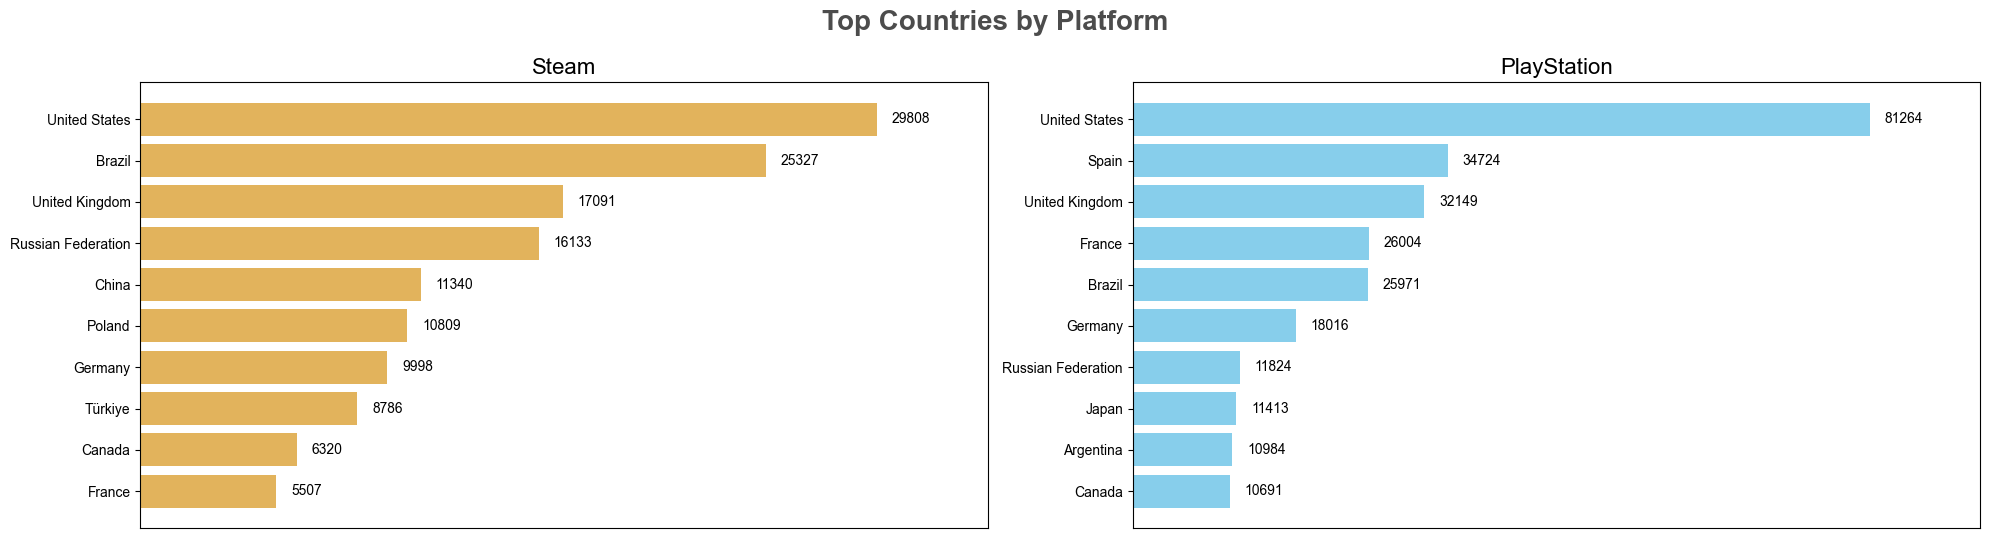

In [17]:
plt.rcParams['font.family'] = 'Arial'
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

for ax, color, platform in zip(axes, COLORS[:2], PLATFORMS[:2]):
    top_country = (
        players_df[platform]
        .country
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'peoples'})
        .head(10)
    )

    bars = ax.barh(top_country.country, top_country.peoples, color=color)

    ax.set_xlim(0, top_country.peoples.max() * 1.15)

    for bar, peoples in zip(bars, top_country.peoples):
        ax.text(
            bar.get_width() + top_country.peoples.max() * .02,
            bar.get_y() + bar.get_height() / 2,
            str(peoples),
            va='center',
            ha='left',
            fontsize=10
        )

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_title(platform.capitalize().replace('s', 'S'), fontsize=16)

fig.text(.5, 1.04, 'Top Countries by Platform',
         ha='center', va='center', fontsize=20, weight='bold', alpha=.7)

plt.tight_layout()